In [1]:
import os
import sys
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
import toolsets.spectra_operations as so
from toolsets.file_io import get_file_list, readin_peak_list, prepare_sample_list
from toolsets.ff_droup import process_mzml, get_EIC_list, EIC
from toolsets.feature_alignment import initilize_pmz_rt_list, find_feature, find_istd, clean_bad_features
from feature_normalization.rt_normalization import rt_normalization
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
# from toolsets.feature_alignment import
from toolsets.search import quick_search_values, string_search
# from feature_finding.feature_finding_alphapept import find_feature
import scipy.stats

In [97]:
def calculate_correlation(alignment_result, bio_data, mode = 'P'):
    if mode =='P':
        mix_name = [x+'_P' for x in bio_data['mix']]
    elif mode == 'N':
        mix_name = [x+'_N' for x in bio_data['mix']]
    peak_height = alignment_result[mix_name]
    correlation = []
    intensity_logged = []
    for index, row in peak_height.iterrows():
        correlation.append(scipy.stats.pearsonr(row.values, bio_data['activity'])[0])
        intensity_logged.append(np.log10(row.values.max()))
        # break
    alignment_result.insert(3, 'correlation', correlation)
    alignment_result.insert(4, 'log10_intensity', intensity_logged)
    return alignment_result, mix_name
def calculate_score(alignment_result_input,active_fraction, mix_name):

    alignment_result = alignment_result_input.copy()
    score = []
    correlation_max = alignment_result['correlation'].max()
    intensity_max = alignment_result['log10_intensity'].max()
    unique_label = []
    for index, row in alignment_result.iterrows():
        score.append(row['correlation']/correlation_max*row['log10_intensity']/intensity_max)
        if row['Spectrum reference file name']==active_fraction and row[mix_name].max()==row[active_fraction]:
            unique_label.append(True)
        else:
            unique_label.append(False)
    score = [x/np.max(score)*100 for x in score]
    alignment_result.insert(3, 'score', score)
    alignment_result.insert(4, 'if_unique', unique_label)
    alignment_result.sort_values(by = 'score', ascending=False, inplace=True)
    return(alignment_result)
def save_files(alignment_result_with_score, result_dir, n = 50):
    alignment_result_with_score.to_csv(os.path.join(result_dir, 'all.csv'), index = False)
    top_correlated = alignment_result_with_score.sort_values(by = 'score', ascending=False)
    top_correlated = top_correlated.iloc[0:n]
    top_correlated.to_csv(os.path.join(result_dir, 'top50_correlated.csv'), index = False)
    unique_compounds = alignment_result_with_score[alignment_result_with_score['if_unique']==True]
    unique_compounds.sort_values(by = 'log10_intensity', ascending=False,inplace=True )
    unique_compounds.iloc[0:n].to_csv(os.path.join(result_dir, 'top50_unique.csv'), index = False)
    joint_compounds = unique_compounds.sort_values(by = 'score', ascending=False)
    joint_compounds.iloc[0:n].to_csv(os.path.join(result_dir, 'joint50.csv'), index = False)

In [98]:
def batch_processing(alignment_result_path, bio_data_path, result_dir, active_fraction, mode = 'P'):
    if mode =='P':
        active_fraction = active_fraction+'_P'
    elif mode == 'N':
        active_fraction = active_fraction+'_N'
    alignment_result = readin_peak_list(alignment_result_path, msial=True)
    bio_data = pd.read_csv(bio_data_path)
    alignment_result, mix_name = calculate_correlation(alignment_result, bio_data, mode = mode)
    # return (alignment_result)
    alignment_result_with_score = calculate_score(alignment_result, active_fraction = active_fraction, mix_name = mix_name)
    save_files(alignment_result_with_score, result_dir)

# 521X

In [72]:
# alignment_result = readin_peak_list('/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/521X/alignment_result/pos/Height_0_20238211528.txt', msial=True)
# bio_data = pd.read_csv('/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/521X/bioactivity/bioacitivity_521X.csv')
# result_dir = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/521X/result/result_pos'
# active_fraction = '521_X8_P'

# 1239 CX

In [99]:
alignment_result_path = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1239CX/alignment_result/pos/Height_0_20238211545.txt'
bio_data_path = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1239CX/bioactivity/bioacitivity_1239CX.csv'
result_dir = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1239CX/result/pos'
active_fraction = '1239_CX'
batch_processing(alignment_result_path = alignment_result_path,
                 bio_data_path=bio_data_path,
                 result_dir=result_dir,
                 active_fraction=active_fraction)

# 1239X

In [103]:
alignment_result_path = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1239X/alignment_result/pos/Height_0_20238211657.txt'
bio_data_path = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1239X/bioactivity/bioacitivity_1239X.csv'
result_dir = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1239X/result/pos'
active_fraction = '1239_X8'
batch_processing(alignment_result_path = alignment_result_path,
                 bio_data_path=bio_data_path,
                 result_dir=result_dir,
                 active_fraction=active_fraction)

# 1782X

In [104]:
alignment_result_path = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1782X/alignment_result/pos/Height_0_20238211747.txt'
bio_data_path = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1782X/bioactivity/bioacitivity_1782X.csv'
result_dir = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1782X/result/pos'
active_fraction = '1782_X8'
batch_processing(alignment_result_path = alignment_result_path,
                 bio_data_path=bio_data_path,
                 result_dir=result_dir,
                 active_fraction=active_fraction)

# exporting to sirius

In [153]:
from toolsets.spectra_operations import convert_msdial_to_string
def export_mgf_shortlist(row, output_dir, mode = 'P'):

    entry = ''
    if mode=='P':
        charge = '1+'
    else:
        charge = '1-'
    pep_mass =row['Average Mz']
    # mass_1, intensity_1 = so.break_spectra(row['ms1'])
    output = os.path.join(output_dir, str(row['rank'])+'_'+str(np.round(row['Average Mz'],3))+'_'+
                          str(np.round(row['Average Rt(min)'],2))+'.mgf')
    # ms1
    entry = entry + 'BEGIN IONS'+'\n'
    entry = entry + 'PEPMASS='+str(pep_mass)+'\n'
    entry = entry + 'MSLEVEL=1'+'\n'
    entry = entry+'CHARGE=' + charge +'\n'
    entry = entry+(so.convert_msdial_to_string(row['MS1 isotopic spectrum']))+'\n'
    entry = entry + 'END IONS'+'\n'

    entry = entry +'\n'
    entry = entry + 'BEGIN IONS'+'\n'
    entry = entry + 'PEPMASS='+str(pep_mass)+'\n'
    entry = entry + 'MSLEVEL=2'+'\n'
    entry = entry+'CHARGE=' + charge +'\n'
    entry = entry+(so.convert_msdial_to_string(row['MS/MS spectrum']))+'\n'
    entry = entry + 'END IONS'+'\n'


    text_file = open(output, "w",encoding='utf-8')
    text_file.write(entry)
    text_file.close()
def export_df(short_list, mgf_dir, figure_dir, bio_data, mode = 'P'):
    short_list.insert(0, 'rank', np.arange(len(short_list)))
    for index, row in short_list.iterrows():
        if row['MS/MS assigned']==True:
            export_mgf_shortlist(row, output_dir=mgf_dir, mode = mode)
            draw_figure(row, bio_data, save_path=figure_dir)


In [157]:
def draw_figure(row, bio_data, save_path = None):
    mix_names = [x+'_P' for x in bio_data['mix']]
    peak_height = row[mix_names]
    fig, axs = plt.subplots(figsize=(10, 6))
    sns.lineplot(x=bio_data['mix'],
                 y=[x / bio_data['activity'].max() for x in bio_data['activity']],
                 color='blue', label='bioactivity')
    sns.lineplot(x=bio_data['mix'], y=[x / peak_height.max() for x in
                                       peak_height], color='orange', marker='D',
                 label='peak_intensity')
    plt.legend(loc='upper right')
    # plt.legend()
    # plt.vlines(x = 7, ymin = 0, ymax = 1, colors='green')
    # plt.vlines(x = 10, ymin = 0, ymax = 1,colors='green')
    plt.xticks(rotation=90)
    axs.grid(False)
    if save_path is None:
        plt.show()
    else:
        plt.savefig(os.path.join(save_path, str(row['rank'])+'_'+str(np.round(row['Average Mz'],3))+'_'+
                                 str(np.round(row['Average Rt(min)'],2))+'.png'))
        plt.close()

In [158]:
short_list_1782x = pd.read_csv('/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1782X/result/pos/joint50.csv')
mgf_dir_1782x = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1782X/sirius/mgf_pos'
bio_data_1782x = pd.read_csv('/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1782X/bioactivity/bioacitivity_1782X.csv')
figure_dir_1782x = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1782X/sirius/figures_pos'
export_df(short_list_1782x, mgf_dir=mgf_dir_1782x, figure_dir=figure_dir_1782x, bio_data=bio_data_1782x)

In [159]:
short_list_521x = pd.read_csv('/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/521X/result/pos/joint50.csv')
mgf_dir_521x = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/521X/sirius/mgf_pos'
bio_data_521x = pd.read_csv('/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/521X/bioactivity/bioacitivity_521X.csv')
figure_dir_521x = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/521X/sirius/figures_pos'
export_df(short_list_521x, mgf_dir=mgf_dir_521x, figure_dir=figure_dir_521x, bio_data=bio_data_521x)


In [3]:
short_list_1239x = pd.read_csv('/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1239X/result/pos/joint50.csv')
# mgf_dir_1239x = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1239x/sirius/mgf_pos'
# bio_data_1239x = pd.read_csv('/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1239X/bioactivity/bioacitivity_1239X.csv')
# figure_dir_1239x = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1239X/sirius/figures_pos'
# export_df(short_list_1239x, mgf_dir=mgf_dir_1239x, figure_dir=figure_dir_1239x, bio_data=bio_data_1239x)

In [26]:
from toolsets.spectra_plotter import head_to_tail_plot, ms2_plot

<module 'matplotlib.pyplot' from '/Users/fanzhou.kong/miniconda3/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

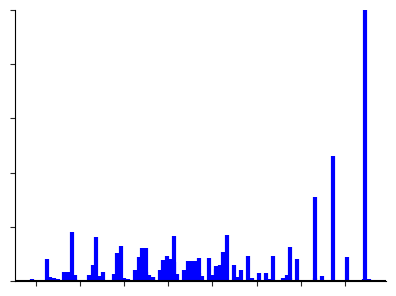

In [27]:
ms2_plot(so.convert_msdial_to_string(short_list_1239x.iloc[0]['MS/MS spectrum']))

In [9]:
mzml_dir_1239x ='/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1239X/mzml/pos'

In [11]:
from toolsets.ff_droup import process_mzml, get_EIC_list, EIC

In [10]:
ms1, ms2 = process_mzml(mzml_path=os.path.join(mzml_dir_1239x, '1239_X8_P.mzML'), rt_max=10, if_mix=False)

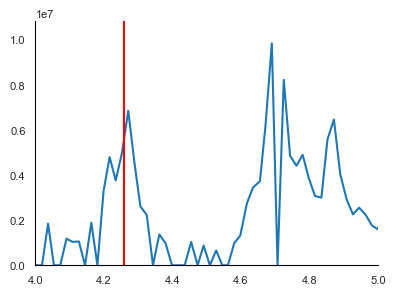

In [21]:
rt_list, intenisty_list =get_EIC_list(ms1, 421.217)
EIC(rt_list, intenisty_list, vlines_location_1=[4.26], rt_start=4, rt_end=5)

In [161]:
short_list_1239cx = pd.read_csv('/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1239CX/result/pos/joint50.csv')
mgf_dir_1239cx = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1239cx/sirius/mgf_pos'
bio_data_1239cx = pd.read_csv('/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1239CX/bioactivity/bioacitivity_1239CX.csv')
figure_dir_1239cx = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Kelleope/1239CX/sirius/figures_pos'
export_df(short_list_1239cx, mgf_dir=mgf_dir_1239cx, figure_dir=figure_dir_1239cx, bio_data=bio_data_1239cx)